In [ ]:
from HelpFunctions.date_and_time import most_recent_thursday, split_time
from DAX.HelpFunctions.get_dax_data import get_dax_data
from datetime import timedelta
from HelpFunctions.calc_score import evaluate_horizon
from HelpFunctions.mix_models import mix_models
import pandas as pd
from DAX.Models.baseline import baseline
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
# import importlib
# importlib.reload(Energy.Models)

In [ ]:
df = get_dax_data()

In [ ]:
# We have to start with the tuesday data
start_date_excl = most_recent_thursday(df) - timedelta(days=1)
df_cval = df.loc[df.index < start_date_excl]
df_cval.index = df_cval.index.date

In [60]:
def evaluate_models(models, df, last_x, years =False, months=False, weeks=False):
    # Check that exactly one of the boolean parameters is True
    if sum([years, months, weeks]) != 1:
        raise ValueError("Exactly one of the boolean parameters (years, months, weeks) must be True.")
    
    years = int(years)
    months = int(months)
    weeks = int(weeks)
        
    for m in models:
        print(f'*********** Start the evaluation of Model {m["name"]} ***********')
        m['evaluation'] = evaluate_model(m, df, last_x, years, months, weeks)
        
def evaluate_model(model, df, last_x, years, months, weeks):
    df_before = df
    evaluation = pd.DataFrame()
    
    for w in range(last_x):
        print(f'Iteration {w+1} of {last_x}')
        df_before, df_after = split_time(df_before, num_years=years, num_months=months, num_weeks=weeks)
        
        pred = None
        # Is mixed model?
        if callable(model['function']):
            pred = model['function'](df_before)
        else: 
            pred = mix_models(model['function'][0], model['function'][1], df_before, target='DAX')
        # Makes sure we try to find observations for dates that have an observation (e.g. 05-01 is missing)
        dates = [[horizon+1, d] for horizon,d in enumerate(pred['forecast_date']) if d in df.index]
        pred = pred.set_index('forecast_date')

        
        # Add observations to pred
        pred['observation'] = ''
        pred['score'] = ''
        for h,d in dates:
            # Look up the right observation for date d
            o = df.loc[d][f'ret{h}']
            pred.loc[d,'observation'] = o
    
        # Add scores to pred
        for index, row in pred.iterrows():
            quantile_preds = row[['q0.025','q0.25','q0.5','q0.75','q0.975']]
            observation = row['observation']
            
            score = evaluate_horizon(quantile_preds, observation)
            
            pred.at[index, 'score'] = score
            
        evaluation = pd.concat([evaluation, pred])
    evaluation = evaluation.sort_index()
    
    return evaluation

In [110]:
from DAX.Models import arma_garch_11 as ag
from DAX.Models import quant_reg as qr
from DAX.Models import baseline as bl
import importlib
importlib.reload(qr)
importlib.reload(bl)

models = [
    {
        'name': 'quant_reg_3_day',
        'function': qr.quant_reg_3d
    },
    {
        'name': 'garch11_norm_1y',
        'function': ag.garch11_norm_1y
    },
    {
        'name': 'baseline',
        'function': bl.baseline
    },
    # {
    #     'name': 'garch11_norm_2y',
    #     'function': ag.garch11_norm_2y
    # },
    # {
    #     'name': 'garch11_norm_5y',
    #     'function': ag.garch11_norm_5y
    # },
]


In [111]:
evaluate_models(models, df, 30, weeks=True)

*********** Start the evaluation of Model quant_reg_3_day ***********
Iteration 1 of 30
  forecast_date target horizon    q0.025     q0.25      q0.5     q0.75  \
0    2024-02-02    DAX   1 day -0.643143 -0.243784  0.014544  0.291876   
0    2024-02-05    DAX   2 day -0.822416 -0.331281  0.104603  0.492386   
0    2024-02-06    DAX   5 day -0.850426 -0.289642  0.261172  0.642076   
0    2024-02-07    DAX   6 day -1.405250 -0.142834  0.327553  0.853956   
0    2024-02-08    DAX   7 day -1.656726 -0.099009  0.553159  1.220577   

     q0.975  
0  0.651419  
0  0.810550  
0  0.850426  
0  2.204211  
0  2.861050  
Iteration 2 of 30
  forecast_date target horizon    q0.025     q0.25      q0.5     q0.75  \
0    2024-01-26    DAX   1 day -1.584941 -0.572066  0.100602  0.645573   
0    2024-01-29    DAX   2 day -1.888440 -0.857705  0.070142  1.023056   
0    2024-01-30    DAX   5 day -2.006821 -1.061663  0.123186  1.330636   
0    2024-01-31    DAX   6 day -2.926851 -1.006401  0.153439  1.43223

/Users/elias/Desktop/PTSFC/venv/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


  forecast_date target horizon    q0.025     q0.25      q0.5     q0.75  \
0    2023-08-25    DAX   1 day -1.125024 -0.415116  0.059953  0.491275   
0    2023-08-28    DAX   2 day -1.399082 -0.599675  0.101170  0.794450   
0    2023-08-29    DAX   5 day -1.480857 -0.661188  0.195894  1.026561   
0    2023-08-30    DAX   6 day -2.060192 -0.584492  0.295707  1.191808   
0    2023-08-31    DAX   7 day -2.653040 -0.499912  0.432489  1.433856   

     q0.975  
0  1.090417  
0  1.363637  
0  1.480857  
0  2.843605  
0  3.602865  
Iteration 25 of 30
  forecast_date target horizon    q0.025     q0.25      q0.5     q0.75  \
0    2023-08-18    DAX   1 day -1.314420 -0.484181  0.075658  0.562646   
0    2023-08-21    DAX   2 day -1.621556 -0.712299  0.091138  0.901391   
0    2023-08-22    DAX   5 day -1.720822 -0.826802  0.168184  1.163883   
0    2023-08-23    DAX   6 day -2.380720 -0.768626  0.251096  1.301755   
0    2023-08-24    DAX   7 day -3.071232 -0.678613  0.395359  1.507651   

     q0

In [112]:
# with open('./Model evaluations/ARMAGARCH11.pkl', 'wb') as f:
#     pickle.dump(models, f)
#         
# with open('./Model evaluations/baseline.pkl', 'rb') as f:
#     models = pickle.load(f)

In [113]:
horizons = [str(i) + " day" for i in (1, 2, 5, 6, 7)]
scores = []
names = []
for h in horizons:
    for m in models:
        col_name = f'{m["name"]}: {h}'
        scores.append(m['evaluation']['score'][m['evaluation']['horizon'] == h])
        names.append(col_name)

score_df = pd.concat(scores, axis=1,keys=names)
score_df = score_df.sort_index()

In [114]:
# score_df

# Plot obtained scores

*** Mean Score ***


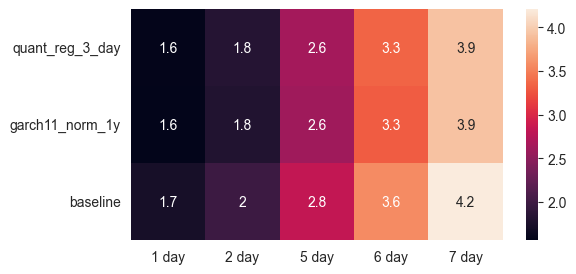

                    1 day     2 day     5 day     6 day     7 day
quant_reg_3_day  1.573522  1.825808  2.646452  3.345027  3.924169
garch11_norm_1y  1.561060  1.792955  2.611281  3.307856  3.924936
baseline         1.726224  1.981822  2.831011  3.576804  4.207527
*** Stds of Scores ***


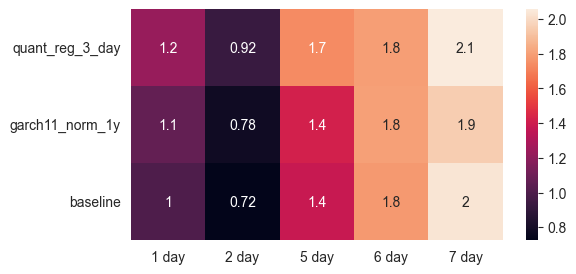

                    1 day     2 day     5 day     6 day     7 day
quant_reg_3_day  1.228505  0.924095  1.738180  1.791342  2.056528
garch11_norm_1y  1.067176  0.777678  1.418398  1.798165  1.949616
baseline         0.995858  0.724538  1.375364  1.780410  2.033507


In [125]:
def print_means_stds(score_df, models_display):
    means = pd.DataFrame(columns=[str(i) + " day" for i in (1, 2, 5, 6, 7)])
    stds = pd.DataFrame(columns=[str(i) + " day" for i in (1, 2, 5, 6, 7)])
    for h in [str(i) + " day" for i in (1, 2, 5, 6, 7)]:
        m = score_df.loc[:,[f'{m}: {h}' for m in models_display]].mean()
        m.index = [m['name'] for m in models]
        means.loc[:,h] = m
        s = score_df.loc[:,[f'{m}: {h}' for m in models_display]].std()
        s.index = [m['name'] for m in models]
        stds.loc[:,h] = s
    print('*** Mean Score ***')
    plt.figure(figsize=(6, 3))
    means = means.astype(float)
    stds = stds.astype(float)
    sns.heatmap(means, annot=True)
    plt.show()
    print(means)
    
    
    print('*** Stds of Scores ***')
    plt.figure(figsize=(6, 3))
    sns.heatmap(stds, annot=True)
    plt.show()
    print(stds)
    
    
print_means_stds(score_df, [m['name'] for m in models])

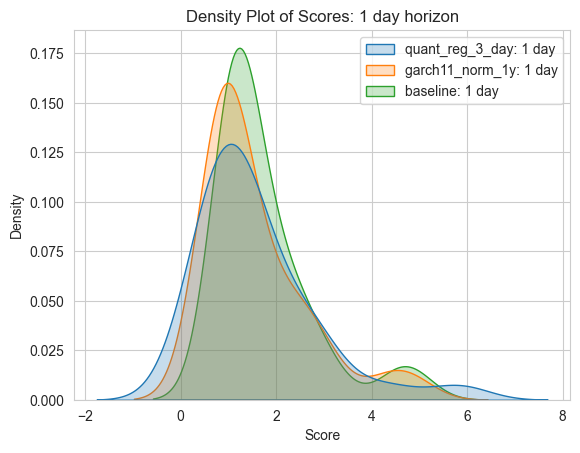

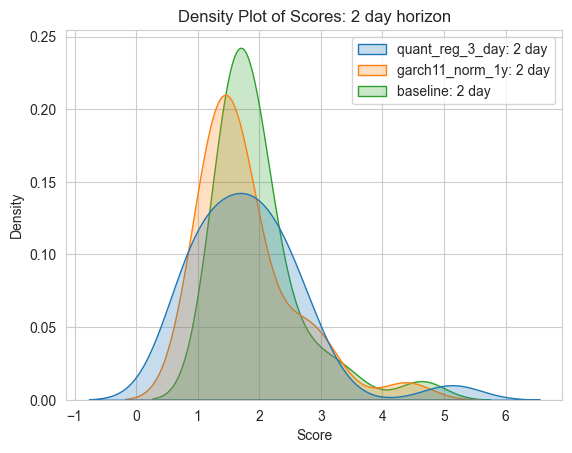

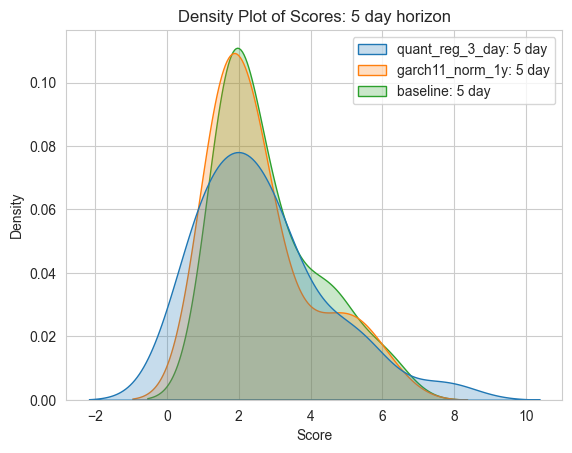

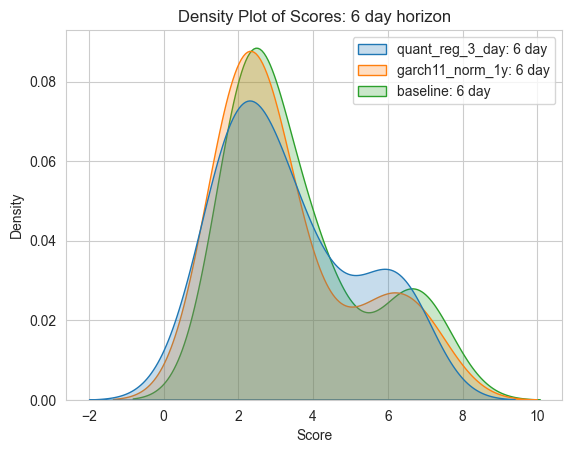

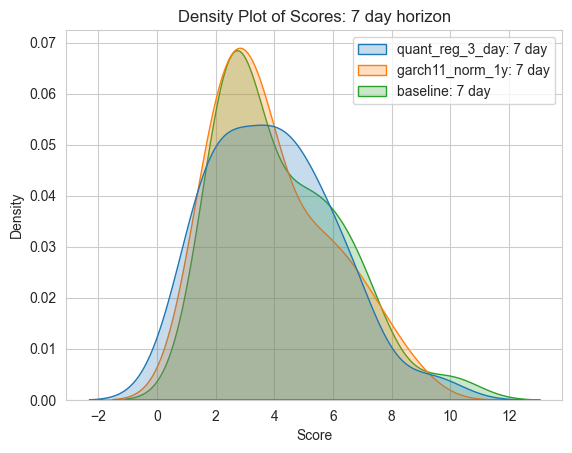

In [116]:
models_display = [m['name'] for m in models]
for h in [str(i) + " day" for i in (1, 2, 5, 6, 7)]:
    sns.kdeplot(data=score_df.loc[:,[f'{m}: {h}' for m in models_display]], fill=True)
    
    # Adding labels and title
    plt.xlabel('Score')
    plt.ylabel('Density')
    plt.title(f'Density Plot of Scores: {h} horizon')

    # Display the plot
    plt.savefig(f'../Plots/density_plot_{h.replace(" ", "_")}.png')
    plt.show()

In [71]:
import statistics
horizon = '1 day'
score_df.loc[:,[f'{m}: {h}' for m in models_display]]
for i,m in enumerate([statistics.mean(score_df.loc[:,f'{m}: {horizon}'].dropna()) for m in models_display]):
    print(f'{models_display[i]} mean score in the past 50 weeks: {m}')

quant_reg mean score in the past 50 weeks: 1.5275565210882445
baseline mean score in the past 50 weeks: 1.7262239319166002


In [ ]:
for h in [str(i) + " day" for i in (1, 2, 5, 6, 7)]:
    score_df_36_no_na = score_df[score_df[f'{models_display[0]}: {h}'].notna()]
    for c in [f'{m}: {h}' for m in models_display]:
        plt.plot(score_df_36_no_na.index, score_df_36_no_na[c], label=c)

    plt.xlabel('time')
    plt.ylabel('score')
    plt.title(f'Comparison of scores over time: {h}')
    # plt.ylim(0,50)
    
    # Display legend
    plt.legend()
    plt.xticks(rotation=45)
    plt.savefig(f'../Plots/line_plot_{h.replace(" ", "_")}.png')

    # Show the plot
    plt.show()

In [ ]:


import matplotlib.pyplot as plt

def plot_evaluation(evaluation_data):
    # Assuming your DataFrame is named df
    numeric_columns = evaluation_data.select_dtypes(include='number')
    
    # Plotting
    plt.figure(figsize=(12, 8))
    for column in numeric_columns.columns:
        plt.plot(evaluation_data.index, evaluation_data[column], label=column)
    plt.plot(evaluation_data.index, evaluation_data['observation'], label = 'observation')
    
    # Adding labels and legend
    plt.xlabel('Forecast Date')
    plt.ylabel('Values')
    plt.title('Visualization of forecast and observation')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.savefig(f'../plots/evaluation_overview.png')
    plt.show()



In [ ]:
model_index = 1
plot_evaluation(models[model_index]['evaluation'][models[model_index]['evaluation']['horizon'] == '5 day'].dropna())

In [ ]:
models[0]['evaluation']